In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from neuromaps import datasets, transforms, images, resampling, nulls, stats

In [2]:
!wb_command -version

Connectome Workbench
Type: Command Line Application
Version: 2.0.1
Qt Compiled Version: 6.2.3
Qt Runtime Version: 6.2.3
Commit: 150de12f4f4b94b39bec6d9133ad2e7019d2d3ef
Commit Date: 2024-10-15 17:38:41 -0500
Compiler: c++ (/Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin)
Compiler Version: 13.0.0.13000029
Compiled Debug: NO
Operating System: Apple OSX
Compiled with OpenMP: YES


In [3]:
brain_maps = [
    {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'},
    {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'},
    {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'},
    {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'},
    {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'},
    {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'},
    {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'},
    {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}
]

single_sphere_counter = 0
for map in brain_maps:
    brain_map = datasets.fetch_annotation(**map)
    if len(brain_map) != 2:
        single_sphere_counter += 1
        print(map)
print(single_sphere_counter)


## Kevin S added
readable_map_names = {
    'genepc1': 'PC1 Gene Expression',
    'myelinmap': 'T1w/T2w Ratio',
    'thickness': 'Cortical Thickness',
    'fcgradient01': 'Functional Gradient',
    'intersubjvar': 'Intersubject Variability',
    'cmrglc': 'Glucose Metabolism',
    'scalingnih': 'Allometric Scaling (NIH)',
    'way100635':' 5-HT1A Receptor'
}


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jespe

In [4]:
def is_volumetric(map_dict):
    """Check if a map is volumetric (MNI space)"""
    return map_dict.get('space') in ['MNI152', 'MNI305']


# Kevin H code
# def load_and_prepare_map(map_dict, target_space='fsLR', target_den='164k'):
#     """
#     Load a brain map and prepare it for analysis
#     - Volumetric maps: transform to surface
#     - Surface maps: resample if needed, use both hemispheres
#     - return (transformed data array, space, density)
#     """
#     print(f"  Loading {map_dict['desc']}...")
    
#     # Fetch the map
#     brain_map = datasets.fetch_annotation(**map_dict)
    
#     # Check if volumetric
#     if is_volumetric(map_dict):
#         print(f"Volumetric map detected, transforming to {target_space} surface...")
        
#         # Transform volumetric to surface (both hemispheres)
#         try:
#             surface_map = transforms.mni152_to_fslr(brain_map, fslr_density=target_den)
#             # surface_map will be a tuple of (left_hemi, right_hemi)
#             lh_data = images.load_data(surface_map[0])
#             rh_data = images.load_data(surface_map[1])
#             full_data = np.hstack([lh_data, rh_data])
#             return full_data, target_space, target_den
            
#         except Exception as e:
#             print(f"    Warning: Could not transform volumetric map: {e}")
 
#     # Surface map processing
#     else:
#         src_space = map_dict.get('space')
#         src_den = map_dict.get('den')
#         template = {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}
#         template_map = datasets.fetch_annotation(**template)
#         # Load both hemispheres
#         if len(brain_map) == 2:
#             lh_map, rh_map = brain_map
#         else:
#             raise ValueError(f"Expected 2 hemispheres for surface map, got {len(brain_map)}")
        
#         # Resample if needed
#         if src_den != target_den or src_space != target_space:
#             print(f"Resampling from {src_space}-{src_den} to {target_space}-{target_den}...")            
#             # Resample both hemispheres
#             lh_resampled, _ = resampling.resample_images(
#                 lh_map, template_map[0],
#                 src_space=src_space, trg_space=target_space,
#                 hemi='L', resampling='transform_to_trg'
#             )
#             rh_resampled, _ = resampling.resample_images(
#                 rh_map, template_map[1],
#                 src_space=src_space, trg_space=target_space,
#                 hemi='R', resampling='transform_to_trg'
#             )
            
#             lh_data = images.load_data(lh_resampled)
#             rh_data = images.load_data(rh_resampled)
#         else:
#             lh_data = images.load_data(lh_map)
#             rh_data = images.load_data(rh_map)
        
#         # Concatenate both hemispheres
#         full_data = np.hstack([lh_data, rh_data])
#         return full_data, src_space if src_den == target_den else target_space, \
#                src_den if src_den == target_den else target_den

## Kevin S code that has incorporate readable_map_names

def load_and_prepare_map(map_dict, readable_map_names=None, target_space='fsLR', target_den='32k'):
    """
    Load a brain map and prepare it for analysis
    - Volumetric maps: transform to surface
    - Surface maps: resample if needed, use both hemispheres
    - return (transformed data array, space, density)
    """
    # Determine display name for logging
    desc = map_dict['desc']
    if readable_map_names and desc in readable_map_names:
        display_name = readable_map_names[desc]
    else:
        display_name = desc

    print(f"  Loading {display_name}...")
    
    # Fetch the map
    brain_map = datasets.fetch_annotation(**map_dict)
    
    # Check if volumetric
    if is_volumetric(map_dict):
        print(f"Volumetric map detected, transforming to {target_space} surface...")
        
        # Transform volumetric to surface (both hemispheres)
        try:
            surface_map = transforms.mni152_to_fslr(brain_map, fslr_density=target_den)
            # surface_map will be a tuple of (left_hemi, right_hemi)
            lh_data = images.load_data(surface_map[0])
            rh_data = images.load_data(surface_map[1])
            full_data = np.hstack([lh_data, rh_data])
            return full_data, target_space, target_den
            
        except Exception as e:
            print(f"    Warning: Could not transform volumetric map: {e}")
 
    # Surface map processing
    else:
        src_space = map_dict.get('space')
        src_den = map_dict.get('den')
        template = {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}
        template_map = datasets.fetch_annotation(**template)
        # Load both hemispheres
        if len(brain_map) == 2:
            lh_map, rh_map = brain_map
        else:
            raise ValueError(f"Expected 2 hemispheres for surface map, got {len(brain_map)}")
        
        # Resample if needed
        if src_den != target_den or src_space != target_space:
            print(f"Resampling from {src_space}-{src_den} to {target_space}-{target_den}...")            
            # Resample both hemispheres
            lh_resampled, _ = resampling.resample_images(
                lh_map, template_map[0],
                src_space=src_space, trg_space=target_space,
                hemi='L', resampling='transform_to_trg'
            )
            rh_resampled, _ = resampling.resample_images(
                rh_map, template_map[1],
                src_space=src_space, trg_space=target_space,
                hemi='R', resampling='transform_to_trg'
            )
            
            lh_data = images.load_data(lh_resampled)
            rh_data = images.load_data(rh_resampled)
        else:
            lh_data = images.load_data(lh_map)
            rh_data = images.load_data(rh_map)
        
        # Concatenate both hemispheres
        full_data = np.hstack([lh_data, rh_data])
        return full_data, src_space if src_den == target_den else target_space, \
               src_den if src_den == target_den else target_den


In [29]:
map = load_and_prepare_map(brain_maps[4])

  Loading way100635...

[References] Please cite the following papers if you are using this data:

  For {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'}:
  [primary]:
    Markus Savli, Andreas Bauer, Markus Mitterhauser, Yu-Shin Ding, Andreas Hahn, Tina Kroll, Alexander Neumeister, Daniela Haeusler, Johanna Ungersboeck, Shannan Henry, and others. Normative database of the serotonergic system in healthy subjects using multi-tracer pet. Neuroimage, 63(1):447–459, 2012.
  [secondary]:
    
Volumetric map detected, transforming to fsLR surface...


In [5]:
def compute_spin_covariance_matrix(brain_maps, n_perm=1000, target_space='fsLR', 
                                   target_den='32k', seed=1234):
    """
    Compute covariance matrix with Alexander-Bloch spin test correction
    Uses BOTH hemispheres for all maps
    
    Returns:
        cov_empirical: Empirical covariance matrix
        cov_pvalues: P-values for each covariance
        cov_corrected: Covariance matrix with non-significant values set to 0
        correlation_matrix: Correlation matrix (standardized covariance)
    """
    n_maps = len(brain_maps)
    prepared_maps = []
    map_names = []
    map_spaces = []
    map_dens = []
    for i, brain_map in enumerate(brain_maps):
        print(f"\nMap {i+1}/{n_maps}: {brain_map['source']} - {brain_map['desc']}")
        try:
            prep_map, final_space, final_den = load_and_prepare_map(
                brain_map, target_space, target_den
            )
            prepared_maps.append(prep_map)
            map_names.append(f"{brain_map['source']}_{brain_map['desc']}")
            map_spaces.append(final_space)
            map_dens.append(final_den)
            print(f"Successfully prepared: {len(prep_map)} vertices")
        except Exception as e:
            print(f"Failed to prepare map: {e}")
            raise
    print("Generating spatial null distributions")
    nulls_list = []
    for i, prep_map in enumerate(prepared_maps):
        print(f"\nMap {i+1}/{n_maps}: {map_names[i]}")
        print(f"  Generating {n_perm} spin rotations...")
        try:
            rotated = nulls.alexander_bloch(
                prep_map,
                atlas=target_space,
                density=target_den,
                n_perm=n_perm,
                seed=seed  # Different seed for each map
            )
            nulls_list.append(rotated)
            print(f"Generated null distribution: shape {rotated.shape}")
        except Exception as e:
            print(f"Failed to generate nulls: {e}")
            raise

    cov_empirical = np.zeros((n_maps, n_maps))
    cov_pvalues = np.ones((n_maps, n_maps))
    corr_empirical = np.zeros((n_maps, n_maps))
    
    # Diagonal elements (variances)
    for i in range(n_maps):
        mask = ~np.isnan(prepared_maps[i])
        cov_empirical[i, i] = np.var(prepared_maps[i][mask])
        cov_pvalues[i, i] = 0.0
        corr_empirical[i, i] = 1.0
    
    # Off-diagonal elements (covariances)
    pair_count = 0
    total_pairs = n_maps * (n_maps - 1) // 2
    
    for i in range(n_maps):
        for j in range(i+1, n_maps):
            pair_count += 1
            print(f"\nPair {pair_count}/{total_pairs}: {map_names[i]} vs {map_names[j]}")
            
            # Check if maps have compatible dimensions
            if len(prepared_maps[i]) != len(prepared_maps[j]):
                print(f"Maps have different lengths: {len(prepared_maps[i])} vs {len(prepared_maps[j])}")
                print(f"Skipping this pair...")
                continue
            
            # Use compare_images to get correlation with spin test
            # This compares rotated versions of map i to ORIGINAL map j
            try:
                corr_emp, p_spin = stats.compare_images(
                    prepared_maps[i],  # source (will be rotated)
                    prepared_maps[j],  # target (stays original)
                    metric='pearsonr',
                    nulls=nulls_list[i],  # rotated versions of source
                    nan_policy='omit'
                )
                
                print(f"Correlation: {corr_emp:.4f}")
                print(f"P-value (spin): {p_spin:.4f} {'***' if p_spin < 0.001 else '**' if p_spin < 0.01 else '*' if p_spin < 0.05 else ''}")
                
                # Store correlation
                corr_empirical[i, j] = corr_emp
                corr_empirical[j, i] = corr_emp
                cov_pvalues[i, j] = p_spin
                cov_pvalues[j, i] = p_spin
                
                # Compute covariance from correlation
                # Cov(X,Y) = Corr(X,Y) * SD(X) * SD(Y)
                mask = ~np.isnan(prepared_maps[i]) & ~np.isnan(prepared_maps[j])
                std_i = np.std(prepared_maps[i][mask])
                std_j = np.std(prepared_maps[j][mask])
                cov_emp = corr_emp * std_i * std_j
                
                cov_empirical[i, j] = cov_emp
                cov_empirical[j, i] = cov_emp
                
                print(f"Covariance: {cov_emp:.6f}")
                print(f"Valid vertices: {np.sum(mask)}/{len(mask)}")
                
            except Exception as e:
                print(f"Failed to compare maps: {e}")
                continue
    
    # Create corrected matrices (only keep significant results)
    cov_corrected = cov_empirical.copy()
    cov_corrected[cov_pvalues > 0.05] = 0
    np.fill_diagonal(cov_corrected, np.diag(cov_empirical))
    
    corr_corrected = corr_empirical.copy()
    corr_corrected[cov_pvalues > 0.05] = 0
    np.fill_diagonal(corr_corrected, 1.0)
    
    corr_corrected = corr_empirical.copy()
    corr_corrected[cov_pvalues > 0.05] = 0
    np.fill_diagonal(corr_corrected, 1.0)
    
    return cov_empirical, cov_pvalues, cov_corrected, corr_empirical, corr_corrected, map_names

In [40]:
import time
start_time = time.perf_counter()

cov_emp, cov_pvals, cov_corr, corr_emp, corr_corr, names = compute_spin_covariance_matrix(
    brain_maps, 
    n_perm=1000,
    target_space='fsLR',
    target_den='32k',  # Using 32k as it's a good middle ground
    seed=1234
)

end_time = time.perf_counter()
cov_corr_df = pd.DataFrame(cov_corr, index=names, columns=names)
print(cov_corr_df)



Map 1/8: abagen - genepc1
  Loading genepc1...

[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker,

In [41]:
cov_corr_df

,abagen_genepc1,hcps1200_myelinmap,hcps1200_thickness,reardon2018_scalingnih,savli2012_way100635,margulies2016_fcgradient01,raichle_cmrglc,mueller2013_intersubjvar
abagen_genepc1,0.879407,0.291597,-0.535008,0.000000,-8.351730,-1.942930,8.039151e+02,-0.071440
hcps1200_myelinmap,0.291597,0.155926,-0.180156,0.000000,-3.204581,-0.821157,0.000000e+00,-0.032289
hcps1200_thickness,-0.535008,-0.180156,0.669394,0.000000,6.551888,1.158190,-6.284991e+02,0.000000
reardon2018_scalingnih,0.000000,0.000000,0.000000,0.114502,0.000000,0.000000,0.000000e+00,0.021048
savli2012_way100635,-8.351730,-3.204581,6.551888,0.000000,162.615509,19.215811,-1.308449e+04,0.753412
margulies2016_fcgradient01,-1.942930,-0.821157,1.158190,0.000000,19.215811,15.770119,0.000000e+00,0.336251
raichle_cmrglc,803.915100,0.000000,-628.499084,0.000000,-13084.491211,0.000000,3.728586e+06,0.000000
mueller2013_intersubjvar,-0.071440,-0.032289,0.000000,0.021048,0.753412,0.336251,0.000000e+00,0.030165


# Kevin S implementation

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

def compute_preliminary_matrix(prepared_maps, map_names, nulls_list, n_perm=1000, readable_map_names=None):
    """
    Computes a PRELIMINARY correlation matrix with standard Spin Tests (Uncorrected).
    Use this for your initial exploration.
    
    Parameters:
    - prepared_maps: List of numpy arrays (N_vertices,) for each map.
    - map_names: List of strings naming each map.
    - nulls_list: List of null arrays (N_vertices, n_perm) for each map.
    - n_perm: Number of permutations used (default 1000).
    - readable_map_names: Dictionary mapping map keys (desc) to readable strings.
    """
    
    print("--- Step 1: Global Masking & Standardization ---")
    data_stack = np.column_stack(prepared_maps)
    
    # Global Mask: Remove vertices where ANY map is missing data
    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    
    clean_data = data_stack[global_mask]
    n_vertices_clean = clean_data.shape[0]
    print(f"Clean vertices used for analysis: {n_vertices_clean}")
    
    # Z-Score to standardize units (Correlation == Covariance)
    clean_data_z = zscore(clean_data, axis=0)
    
    print("\n--- Step 2: Compute Real Correlation Matrix (Pearson) ---")
    real_corr = (clean_data_z.T @ clean_data_z) / n_vertices_clean
    
    print("\n--- Step 3: Compute Spin P-Values (Uncorrected) ---")
    p_counts = np.zeros((len(prepared_maps), len(prepared_maps)))
    
    clean_nulls_list = [n[global_mask, :] for n in nulls_list]
    
    for k in range(n_perm):
        if k % 100 == 0: print(f"Permutation {k}/{n_perm}...")
        
        null_data_k = np.zeros_like(clean_data_z)
        for m in range(len(prepared_maps)):
            spin_k = clean_nulls_list[m][:, k]
            null_data_k[:, m] = zscore(spin_k, nan_policy='omit')
            
        null_corr_k = np.corrcoef(null_data_k.T)
        
        # Check: Is random correlation stronger than real correlation?
        is_stronger = np.abs(null_corr_k) >= np.abs(real_corr)
        p_counts += is_stronger.astype(int)

    p_values = (p_counts + 1) / (n_perm + 1)
    
    print("\n--- Step 4: Finalizing ---")
    
    # Resolve readable names for the DataFrame columns/indices
    display_names = map_names
    if readable_map_names is not None:
        display_names = []
        for name in map_names:
            # name is typically "source_desc" (e.g. abagen_genepc1)
            # readable_map_names keys are typically "desc" (e.g. genepc1)
            
            # 1. Check for direct match
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
                
            # 2. Check if name ends with "_desc" corresponding to a key
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            
            if not found_match:
                display_names.append(name) # Fallback to original if no match found
    
    df_corr = pd.DataFrame(real_corr, index=display_names, columns=display_names).round(3)
    df_pvals = pd.DataFrame(p_values, index=display_names, columns=display_names).round(3)
    
    # Mask non-significant values (p > 0.05)
    df_significant = df_corr.copy()
    df_significant[df_pvals > 0.05] = 0
    
    return df_corr, df_pvals, df_significant

def plot_correlation_heatmaps(df_corr, df_significant):
    """
    Plots two side-by-side heatmaps: 
    1. The Full Correlation Matrix
    2. The Significant-Only Matrix (Non-significant cells masked)
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10)) # Increased height for rotated labels
    
    # Plot 1: Full Matrix
    sns.heatmap(
        df_corr, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu_r', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        ax=axes[0],
        cbar_kws={'label': 'Pearson r'}
    )
    axes[0].set_title("Full Correlation Matrix (Raw)", fontsize=16)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)
    
    # Plot 2: Significant Only
    # Create a mask for zero values (non-significant) so they appear white/grey
    mask = (df_significant == 0)
    
    sns.heatmap(
        df_significant, 
        annot=True, 
        fmt=".2f", 
        cmap='RdBu_r', 
        center=0, 
        vmin=-1, vmax=1,
        square=True,
        mask=mask, # Hides the non-significant cells
        ax=axes[1],
        cbar_kws={'label': 'Pearson r'}
    )
    axes[1].set_title("Significant Correlations Only (p < 0.05)", fontsize=16)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()

In [7]:
# --- RUN THIS CELL TO PREPARE DATA ---

prepared_maps = []
map_names = []
nulls_list = []
n_perm = 1000

print("1. Loading Maps and Generating Nulls...")

for i, b_map in enumerate(brain_maps):
    # Pass readable_map_names so the loading function prints nice names
    prep_data, _, _ = load_and_prepare_map(
        b_map, 
        readable_map_names=readable_map_names, 
        target_space='fsLR', 
        target_den='32k'
    )
    prepared_maps.append(prep_data)
    
    # Keep the technical name for internal tracking, we resolve to readable later
    name = f"{b_map['source']}_{b_map['desc']}"
    map_names.append(name)
    
    # Generate Nulls
    # Get nice name for print statement
    desc = b_map['desc']
    display_name = readable_map_names.get(desc, desc)
    
    print(f"  Generating {n_perm} spins for {display_name}...")
    rotated = nulls.alexander_bloch(
        prep_data, 
        atlas='fsLR', 
        density='32k', 
        n_perm=n_perm, 
        seed=1234 + i 
    )
    nulls_list.append(rotated)

print("\nDone! Data is ready for matrix computation.")
# takes about 12 min to run

1. Loading Maps and Generating Nulls...
  Loading PC1 Gene Expression...

[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C

--- Step 1: Global Masking & Standardization ---
Clean vertices used for analysis: 57830

--- Step 2: Compute Real Correlation Matrix (Pearson) ---

--- Step 3: Compute Spin P-Values (Uncorrected) ---
Permutation 0/1000...
Permutation 100/1000...
Permutation 200/1000...
Permutation 300/1000...
Permutation 400/1000...
Permutation 500/1000...
Permutation 600/1000...
Permutation 700/1000...
Permutation 800/1000...
Permutation 900/1000...

--- Step 4: Finalizing ---

--- Correlation Matrix (Pearson r) ---


,PC1 Gene Expression,T1w/T2w Ratio,Cortical Thickness,Allometric Scaling (NIH),5-HT1A Receptor,Functional Gradient,Glucose Metabolism,Intersubject Variability
PC1 Gene Expression,1.000,0.793,-0.700,-0.142,-0.708,-0.520,0.441,-0.436
T1w/T2w Ratio,0.793,1.000,-0.572,-0.194,-0.663,-0.552,0.381,-0.482
Cortical Thickness,-0.700,-0.572,1.000,0.151,0.627,0.373,-0.417,0.291
Allometric Scaling (NIH),-0.142,-0.194,0.151,1.000,0.171,0.225,0.048,0.348
5-HT1A Receptor,-0.708,-0.663,0.627,0.171,1.000,0.394,-0.530,0.377
Functional Gradient,-0.520,-0.552,0.373,0.225,0.394,1.000,0.084,0.494
Glucose Metabolism,0.441,0.381,-0.417,0.048,-0.530,0.084,1.000,0.093
Intersubject Variability,-0.436,-0.482,0.291,0.348,0.377,0.494,0.093,1.000



--- Significant Correlations (p < 0.05) ---


,PC1 Gene Expression,T1w/T2w Ratio,Cortical Thickness,Allometric Scaling (NIH),5-HT1A Receptor,Functional Gradient,Glucose Metabolism,Intersubject Variability
PC1 Gene Expression,1.000,0.793,-0.700,-0.142,-0.708,-0.520,0.441,-0.436
T1w/T2w Ratio,0.793,1.000,-0.572,0.000,-0.663,-0.552,0.000,-0.482
Cortical Thickness,-0.700,-0.572,1.000,0.000,0.627,0.373,0.000,0.000
Allometric Scaling (NIH),-0.142,0.000,0.000,1.000,0.000,0.000,0.000,0.000
5-HT1A Receptor,-0.708,-0.663,0.627,0.000,1.000,0.394,-0.530,0.000
Functional Gradient,-0.520,-0.552,0.373,0.000,0.394,1.000,0.000,0.494
Glucose Metabolism,0.441,0.000,0.000,0.000,-0.530,0.000,1.000,0.000
Intersubject Variability,-0.436,-0.482,0.000,0.000,0.000,0.494,0.000,1.000


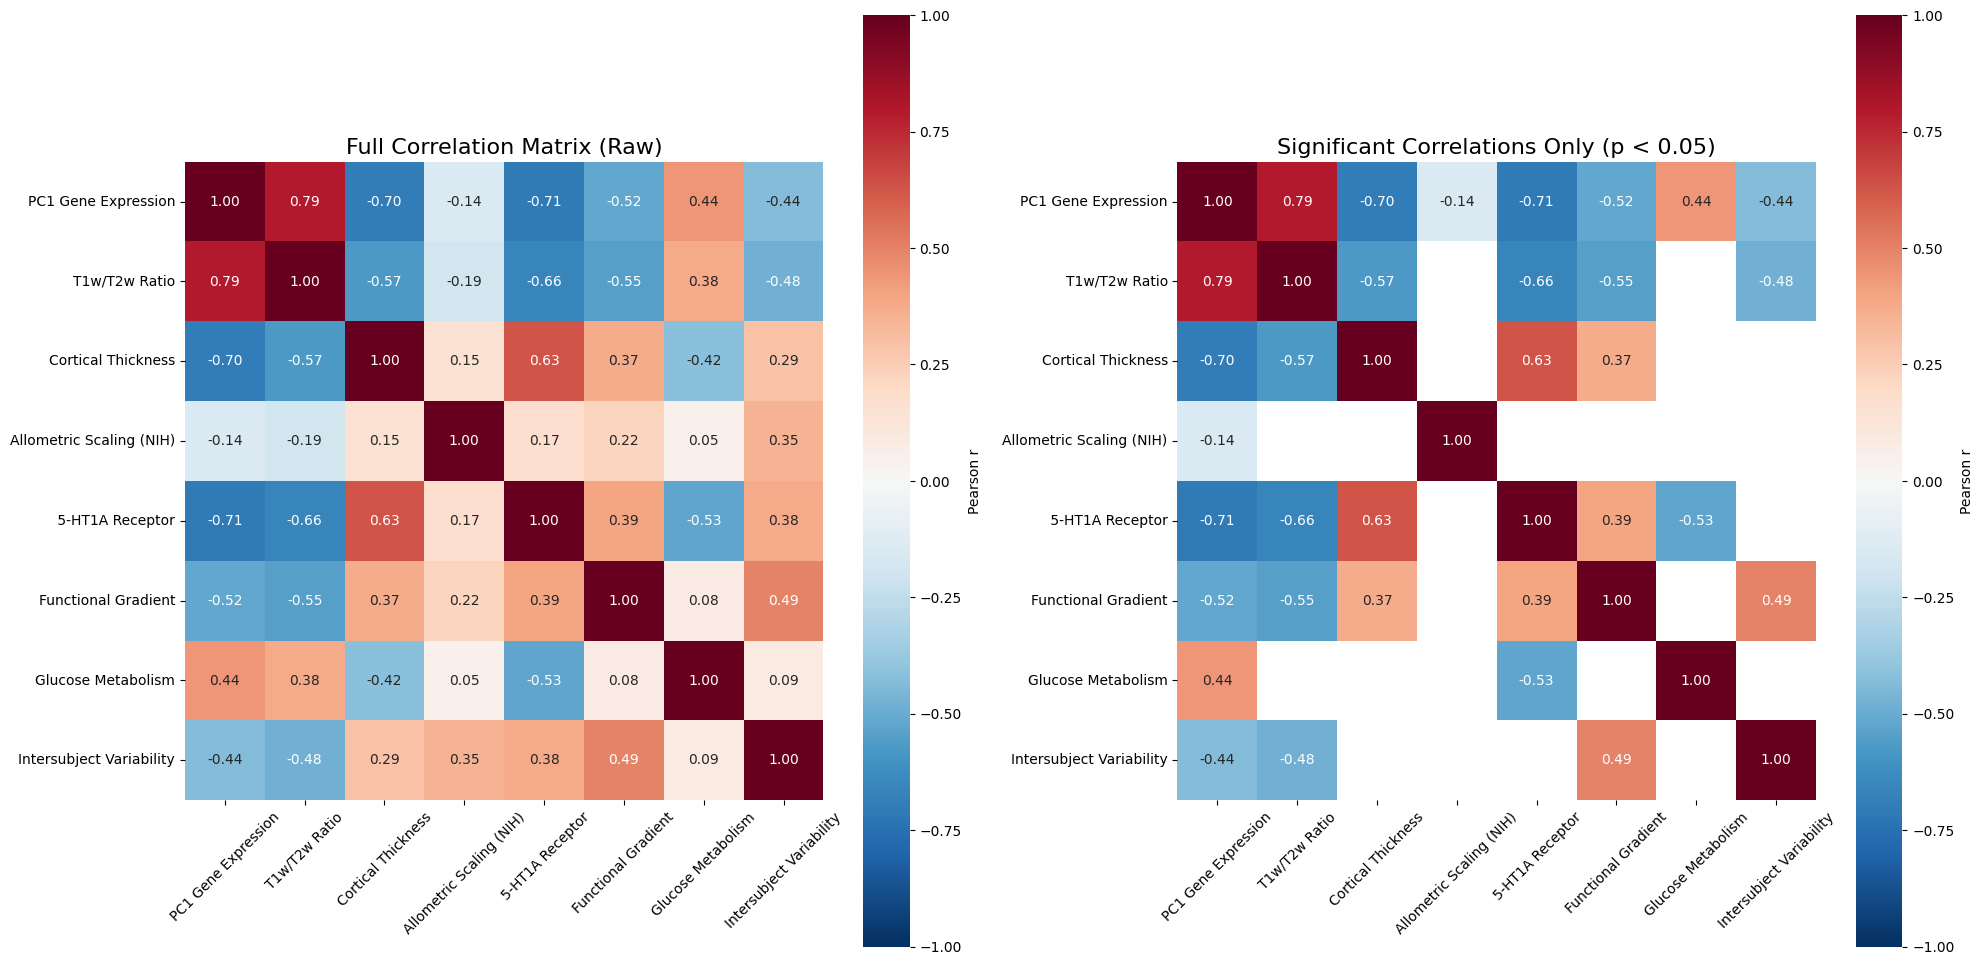

In [8]:
# --- RUN THIS CELL TO COMPUTE MATRIX ---

# Call the function from analysis_pipeline.py
# We pass readable_map_names here so the tables use the clean names
df_corr, df_pvals, df_significant = compute_preliminary_matrix(
    prepared_maps, 
    map_names, 
    nulls_list, 
    n_perm=1000,
    readable_map_names=readable_map_names
)

# Display the results
print("\n--- Correlation Matrix (Pearson r) ---")
display(df_corr)

print("\n--- Significant Correlations (p < 0.05) ---")
display(df_significant)

# Optional: Plot the heatmaps immediately
plot_correlation_heatmaps(df_corr, df_significant)

For the above tables:
- Significant correlations
    - if any relationship failed the spin test, then the value is 0 in the table

In [1]:
from scipy.stats import zscore, rankdata

In [9]:
## Spearman Rank
def compute_preliminary_matrix_spearman(prepared_maps, map_names, nulls_list, n_perm=1000, readable_map_names=None):
    """
    Computes a PRELIMINARY correlation matrix using SPEARMAN RANK CORRELATION.
    Use this if your data has non-linear monotonic relationships.
    
    Parameters:
    - prepared_maps: List of numpy arrays (N_vertices,) for each map.
    - map_names: List of strings naming each map.
    - nulls_list: List of null arrays (N_vertices, n_perm) for each map.
    - n_perm: Number of permutations used (default 1000).
    - readable_map_names: Dictionary mapping map keys (desc) to readable strings.
    """
    
    print("--- Step 1: Global Masking & Ranking ---")
    data_stack = np.column_stack(prepared_maps)
    
    # Global Mask: Remove vertices where ANY map is missing data
    global_mask = np.all((~np.isnan(data_stack)) & (data_stack != 0), axis=1)
    
    clean_data = data_stack[global_mask]
    n_vertices_clean = clean_data.shape[0]
    print(f"Clean vertices used for analysis: {n_vertices_clean}")
    
    # TRANSFORMATION FOR SPEARMAN: Rank the data
    # We rank down each column (axis=0)
    # This converts raw values to ranks (1st, 2nd, 3rd...)
    # NOTE: This is where Spearman differs from Pearson
    clean_data_ranked = np.apply_along_axis(rankdata, 0, clean_data)
    
    # Z-Score the RANKS (Standardization)
    # Pearson on Ranks == Spearman on Raw Data
    clean_data_z = zscore(clean_data_ranked, axis=0)
    
    print("\n--- Step 2: Compute Real Correlation Matrix (Spearman) ---")
    # Matrix multiplication on ranked data gives Spearman Rho
    real_corr = (clean_data_z.T @ clean_data_z) / n_vertices_clean
    
    print("\n--- Step 3: Compute Spin P-Values (Uncorrected) ---")
    p_counts = np.zeros((len(prepared_maps), len(prepared_maps)))
    
    clean_nulls_list = [n[global_mask, :] for n in nulls_list]
    
    for k in range(n_perm):
        if k % 100 == 0: print(f"Permutation {k}/{n_perm}...")
        
        null_data_k = np.zeros_like(clean_data_z)
        for m in range(len(prepared_maps)):
            spin_k = clean_nulls_list[m][:, k]
            
            # CRITICAL: We must RANK the null data too for valid Spearman comparison
            # Handle NaNs if spins introduced them (though global mask helps)
            spin_k_ranked = rankdata(spin_k, nan_policy='omit')
            
            null_data_k[:, m] = zscore(spin_k_ranked, nan_policy='omit')
            
        null_corr_k = np.corrcoef(null_data_k.T)
        
        # Check: Is random correlation stronger than real correlation?
        is_stronger = np.abs(null_corr_k) >= np.abs(real_corr)
        p_counts += is_stronger.astype(int)

    p_values = (p_counts + 1) / (n_perm + 1)
    
    print("\n--- Step 4: Finalizing ---")
    
    # Resolve readable names
    display_names = map_names
    if readable_map_names is not None:
        display_names = []
        for name in map_names:
            if name in readable_map_names:
                display_names.append(readable_map_names[name])
                continue
            found_match = False
            for key, val in readable_map_names.items():
                if name.endswith(f"_{key}"):
                    display_names.append(val)
                    found_match = True
                    break
            if not found_match:
                display_names.append(name)
    
    df_corr = pd.DataFrame(real_corr, index=display_names, columns=display_names).round(3)
    df_pvals = pd.DataFrame(p_values, index=display_names, columns=display_names).round(3)
    
    # Mask non-significant values (p > 0.05)
    df_significant = df_corr.copy()
    df_significant[df_pvals > 0.05] = 0
    
    return df_corr, df_pvals, df_significant

--- Step 1: Global Masking & Ranking ---
Clean vertices used for analysis: 57830

--- Step 2: Compute Real Correlation Matrix (Spearman) ---

--- Step 3: Compute Spin P-Values (Uncorrected) ---
Permutation 0/1000...
Permutation 100/1000...
Permutation 200/1000...
Permutation 300/1000...
Permutation 400/1000...
Permutation 500/1000...
Permutation 600/1000...
Permutation 700/1000...
Permutation 800/1000...
Permutation 900/1000...

--- Step 4: Finalizing ---

--- Correlation Matrix (Spearman rho) ---


,PC1 Gene Expression,T1w/T2w Ratio,Cortical Thickness,Allometric Scaling (NIH),5-HT1A Receptor,Functional Gradient,Glucose Metabolism,Intersubject Variability
PC1 Gene Expression,1.000,0.842,-0.665,-0.117,-0.690,-0.595,0.340,-0.477
T1w/T2w Ratio,0.842,1.000,-0.553,-0.150,-0.671,-0.629,0.333,-0.499
Cortical Thickness,-0.665,-0.553,1.000,0.147,0.595,0.399,-0.366,0.269
Allometric Scaling (NIH),-0.117,-0.150,0.147,1.000,0.225,0.252,-0.013,0.342
5-HT1A Receptor,-0.690,-0.671,0.595,0.225,1.000,0.519,-0.391,0.497
Functional Gradient,-0.595,-0.629,0.399,0.252,0.519,1.000,0.092,0.612
Glucose Metabolism,0.340,0.333,-0.366,-0.013,-0.391,0.092,1.000,0.089
Intersubject Variability,-0.477,-0.499,0.269,0.342,0.497,0.612,0.089,1.000



--- Significant Correlations (p < 0.05) ---


,PC1 Gene Expression,T1w/T2w Ratio,Cortical Thickness,Allometric Scaling (NIH),5-HT1A Receptor,Functional Gradient,Glucose Metabolism,Intersubject Variability
PC1 Gene Expression,1.000,0.842,-0.665,-0.117,-0.690,-0.595,0.34,-0.477
T1w/T2w Ratio,0.842,0.000,-0.553,0.000,-0.671,-0.629,0.00,-0.499
Cortical Thickness,-0.665,-0.553,0.000,0.000,0.595,0.399,0.00,0.000
Allometric Scaling (NIH),-0.117,0.000,0.000,1.000,0.000,0.000,0.00,0.342
5-HT1A Receptor,-0.690,-0.671,0.595,0.000,0.000,0.519,0.00,0.497
Functional Gradient,-0.595,-0.629,0.399,0.000,0.519,1.000,0.00,0.612
Glucose Metabolism,0.340,0.000,0.000,0.000,0.000,0.000,1.00,0.000
Intersubject Variability,-0.477,-0.499,0.000,0.342,0.497,0.612,0.00,1.000


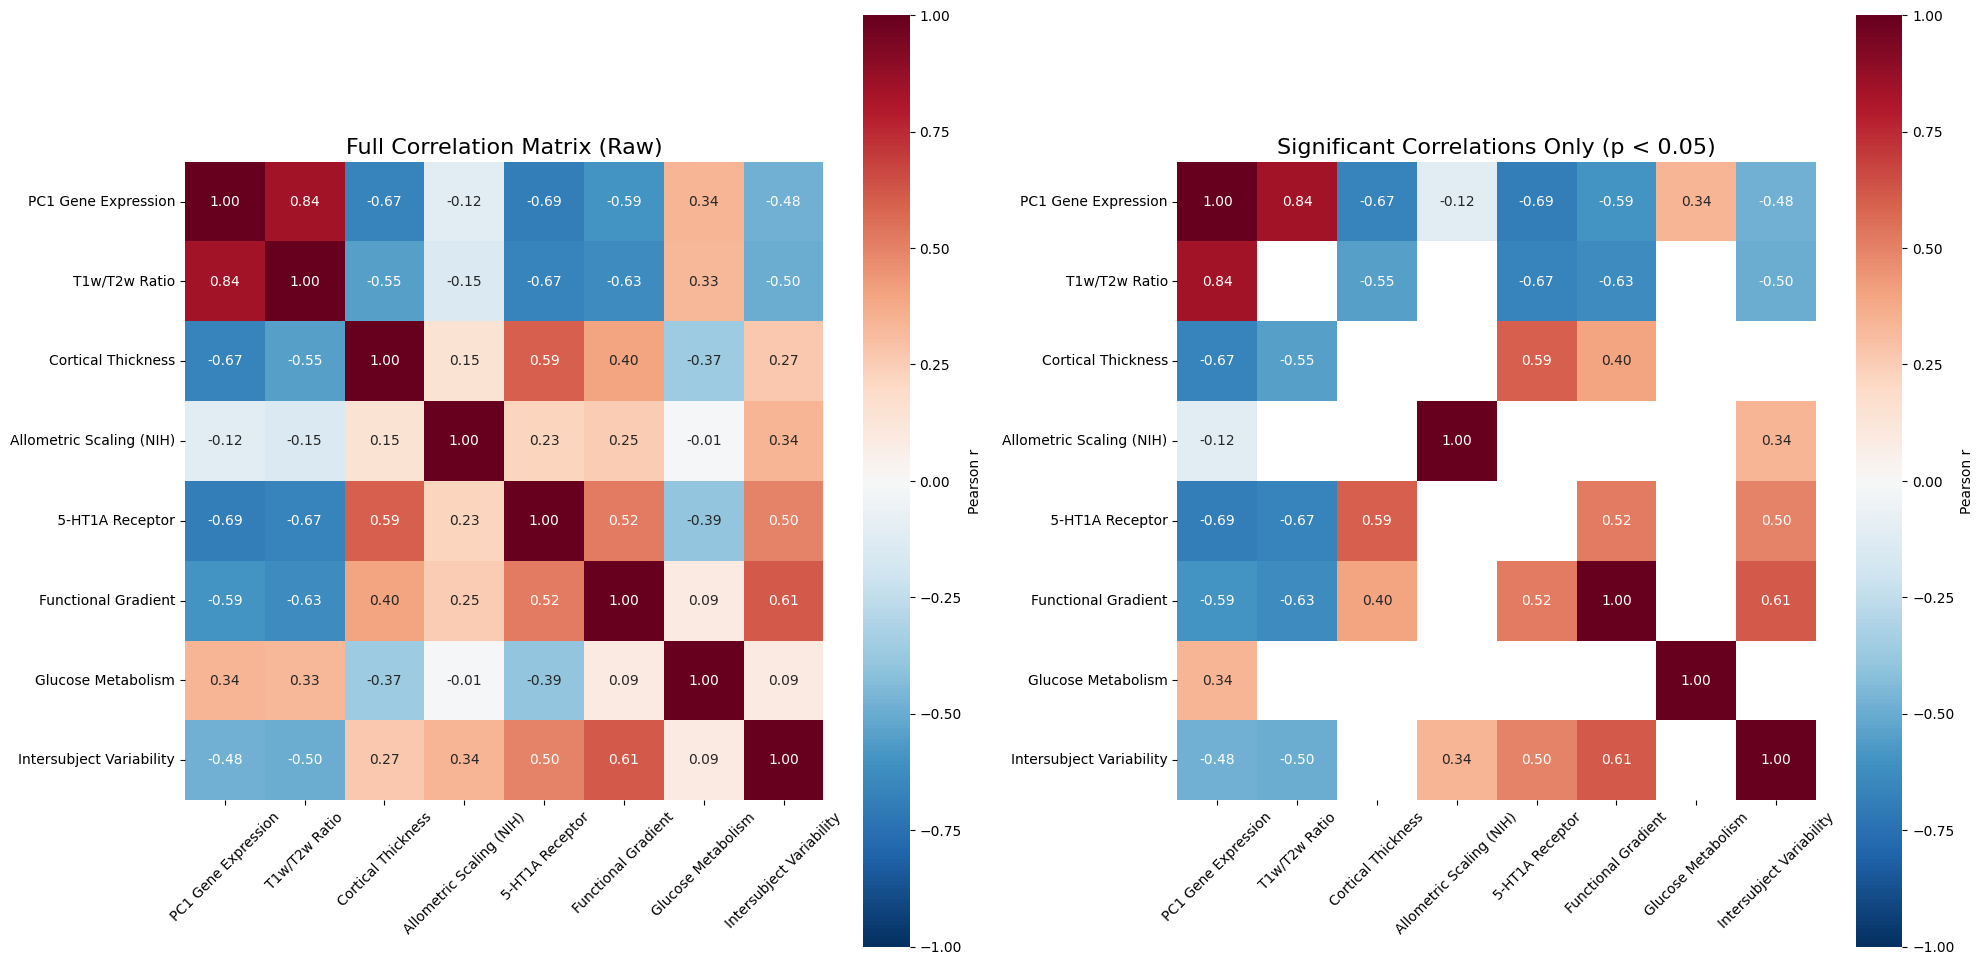

In [10]:
# --- RUN THIS CELL TO COMPUTE MATRIX ---

# Call the function from analysis_pipeline.py
# We pass readable_map_names here so the tables use the clean names
df_corr, df_pvals, df_significant = compute_preliminary_matrix_spearman(
    prepared_maps, 
    map_names, 
    nulls_list, 
    n_perm=1000,
    readable_map_names=readable_map_names
)

# Display the results
print("\n--- Correlation Matrix (Spearman rho) ---")
display(df_corr)

print("\n--- Significant Correlations (p < 0.05) ---")
display(df_significant)

# Optional: Plot the heatmaps immediately
plot_correlation_heatmaps(df_corr, df_significant)